# **import**

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# **data**

In [3]:
TEMPERATURES_CSV = './sample_data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        day = 0
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for line in reader:
          times.append(day)
          temperatures.append(float(line[1]))
          day = day + 1


    return times, temperatures


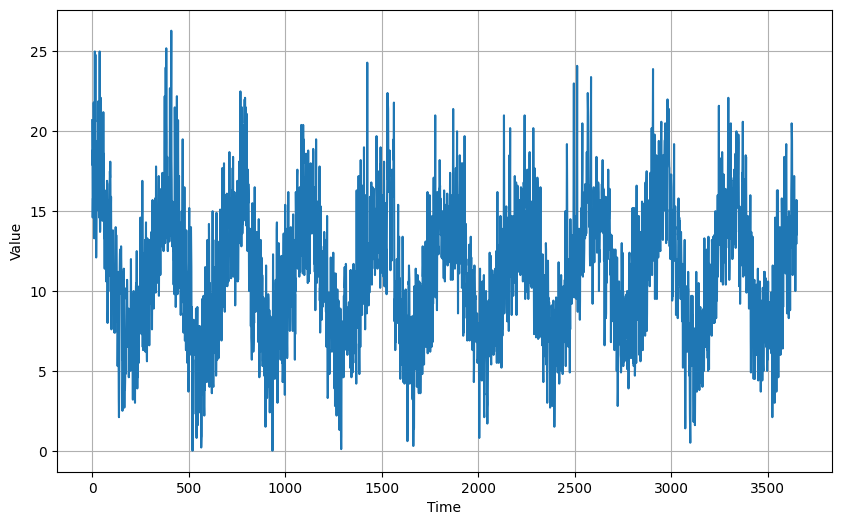

In [6]:
# Test your function
@dataclass
class G:
    TEMPERATURES_CSV = './sample_data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [7]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
     # Create dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## model architecture



In [ ]:
def create_uncompiled_model():


    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[30, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)

    ])


    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

77/77 [==============================] - 2s 15ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate


In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-12 * 10**((epoch+9) / 10))

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])


    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
#dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 6s 49ms/step - loss: 20.9422 - mae: 21.4414 - lr: 7.9433e-12
Epoch 2/100
77/77 [==============================] - 4s 50ms/step - loss: 20.9334 - mae: 21.4327 - lr: 1.0000e-11
Epoch 3/100
77/77 [==============================] - 4s 53ms/step - loss: 20.9215 - mae: 21.4208 - lr: 1.2589e-11
Epoch 4/100
77/77 [==============================] - 4s 48ms/step - loss: 20.9057 - mae: 21.4050 - lr: 1.5849e-11
Epoch 5/100
77/77 [==============================] - 4s 55ms/step - loss: 20.8846 - mae: 21.3839 - lr: 1.9953e-11
Epoch 6/100
77/77 [==============================] - 4s 47ms/step - loss: 20.8570 - mae: 21.3563 - lr: 2.5119e-11
Epoch 7/100
77/77 [==============================] - 4s 46ms/step - loss: 20.8210 - mae: 21.3203 - lr: 3.1623e-11
Epoch 8/100
77/77 [==============================] - 4s 47ms/step - loss: 20.7754 - mae: 21.2747 - lr: 3.9811e-11
Epoch 9/100
77/77 [==============================] - 4s 47ms/step - loss: 20.7166 - mae:

(1e-11, 1.0, 0.0, 1000.0)

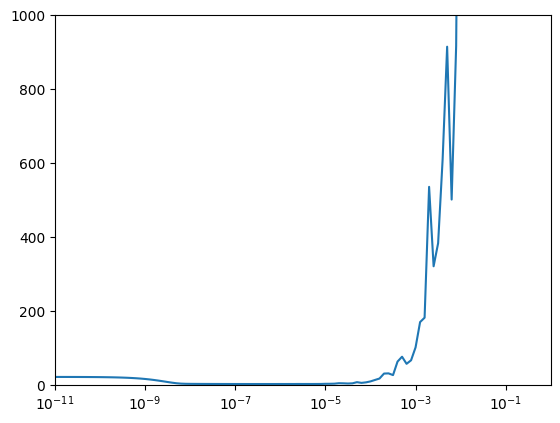

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-11, 1, 0, 1000])

In [ ]:
def create_model():


    model = create_uncompiled_model()


    learning_rate = 8e-7
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])


    return model

In [ ]:
model = create_model()
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 7s 49ms/step - loss: 7.9365 - mae: 8.4218
Epoch 2/50
77/77 [==============================] - 4s 49ms/step - loss: 5.4097 - mae: 5.8950
Epoch 3/50
77/77 [==============================] - 4s 56ms/step - loss: 4.3576 - mae: 4.8339
Epoch 4/50
77/77 [==============================] - 4s 50ms/step - loss: 3.5516 - mae: 4.0223
Epoch 5/50
77/77 [==============================] - 4s 50ms/step - loss: 2.9550 - mae: 3.4191
Epoch 6/50
77/77 [==============================] - 4s 49ms/step - loss: 2.5836 - mae: 3.0442
Epoch 7/50
77/77 [==============================] - 4s 50ms/step - loss: 2.3766 - mae: 2.8392
Epoch 8/50
77/77 [==============================] - 4s 55ms/step - loss: 2.2536 - mae: 2.7135
Epoch 9/50
77/77 [==============================] - 4s 48ms/step - loss: 2.1872 - mae: 2.6427
Epoch 10/50
77/77 [==============================] - 4s 48ms/step - loss: 2.1439 - mae: 2.5995
Epoch 11/50
77/77 [==============================] - 4s 49m

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts



In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 2s 15ms/step


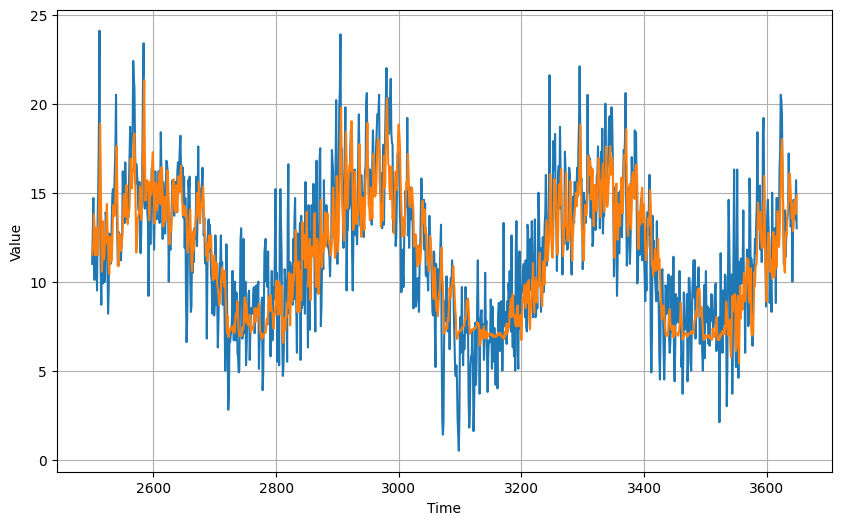

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 6.53, mae: 2.01 for forecast


In [ ]:

model.save('saved_model/my_model')

! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/assets/
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/fingerprint.pb


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**